Epoch: 1000 cost = 0.447754
Epoch: 2000 cost = 0.318689
Epoch: 3000 cost = 0.240222
Epoch: 4000 cost = 0.186729
Epoch: 5000 cost = 0.147145
Epoch: 6000 cost = 0.116477
Epoch: 7000 cost = 0.092232
Epoch: 8000 cost = 0.072950
'book is sports' is subjective
'i hate soccer' is objective


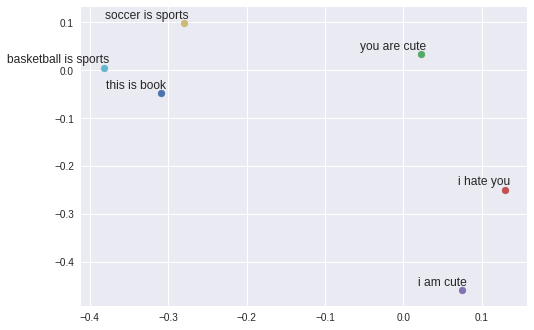

In [0]:
'''
  code by Minho Ryu @bzantium
  
'''
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

from torch import FloatTensor as FT
from torch import LongTensor as LT

num_classes = 2 # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["this is book","you are cute", "i hate you", "i am cute","soccer is sports", "basketball is sports"]
test_sents = ["book is sports", "i hate soccer"] # [subjective, objective]
targets = [1,0,0,0,1,1] # 1 is objective, 0 is subjective.

tokens = []
for sent in sentences:
  tokens.append(sent.split())

test_tokens = []
for sent in test_sents:
  test_tokens.append(sent.split())
  
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)

tagged = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(tokens)]

num_epochs_per_cycle = 5
num_cycles = 20
vec_size = 2
num_classes = 2
alpha = 1e-1
min_alpha = 1e-3
doc2vec = Doc2Vec(vector_size=vec_size, alpha=alpha, min_count=2, dm=0)
doc2vec.build_vocab(tagged)
for cycle in range(num_cycles):
    doc2vec.train(tagged, total_examples=doc2vec.corpus_count,
                epochs=num_epochs_per_cycle, start_alpha=alpha, end_alpha=min_alpha)

inputs = []
for i in range(len(sentences)):
    inputs.append(doc2vec.docvecs[str(i)])

tests = []
for i in range(len(test_sents)):
    tests.append(doc2vec.infer_vector(test_tokens[i], alpha=alpha, min_alpha=min_alpha, steps=5))
    
class FullyConnected(nn.Module):
    def __init__(self, vec_size, num_classes):
        super(FullyConnected, self).__init__()
        self.linear = nn.Linear(vec_size, num_classes)
        
    def forward(self, x):
        return self.linear(x)
        
model = FullyConnected(vec_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

inputs = FT(inputs)
tests = FT(tests)
targets = LT(targets)

for epoch in range(8000):
    optimizer.zero_grad()
    output = model(inputs)

    # output : [batch_size, num_classes], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, targets)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Predict
model.eval()
result = model(tests).data.max(1)[1]

for i, text in enumerate(test_sents):
  if result[i] == 0:
      print("\'" + text + "\'", "is subjective")
  else:
      print("\'"+ text + "\'", "is objective")
      

for i, label in enumerate(sentences):
    x, y = inputs[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()